# Heart Rate FFT

## Plotting mean intensity over time. 

Firstly we need to import the required packages and the movie as individual frames.
- Matplotlib.pyplot is installed for graphing the data
- VideoReader is imported to extract frame data from the video file
- Numpy is installed for some stats and calculating the FFT and Power
- CV2 is installed for image processing

In [1]:
import matplotlib.pyplot as plt
from videoreader import VideoReader
import cv2
import numpy as np

Now we can import the video file data into an array of frames using VideoReader

In [2]:
vr = VideoReader('video_of_finger.MOV')
print(vr)  # This prints the number of frames, frame size (including RGB), and framerate (sampling freq).

video_of_finger.MOV with 1852 frames of size (1920, 1080, 3) at 29.98 fps


This turns the frames from RGB to flattened grayscale frames.

I was originally using RGB2GRAY, however this calculated extremely low intensities so I swapped to BGR2GRAY from CV2.

In [3]:
## Firstly we create an empty array which we will import the frames into in the following loop.

vr_gray = [] 
for image in range(len(vr)):
    vr_gray.append(cv2.cvtColor(vr[image], cv2.COLOR_BGR2GRAY)) 
    
## This loop loops through each frame in the VR variable (the video), turns each frame grayscale, and appends
## each grayscale image into the vr_gray array.

In [4]:
## Similarly to the previous code, this creates an empty mean_intensity array in which we append the mean
## value of each grayscale frame through a loop of the vr_gray array. 

mean_intensity = []
for i in range(len(vr_gray)):
    mean_intensity.append(vr_gray[i].mean())

In [5]:
## To calculate the overall time of the video I use the number of frames divided by the sampling frequency

time = 1852 / 29.98
time

61.77451634422948

In [6]:
## This code creates an array of the time points for each frame. This is done by calculating an interval and
## forming equally spaced time points from the start to the end.

sampling_frequency = 29.98
interval = 1/sampling_frequency ## This calculates the time interval, as we know there are 29,98 frames per second
time_elapsed = np.arange(0, time, interval) ## This arranges values from the start 0, to the end 61.77s by the interval
time_elapsed

array([0.00000000e+00, 3.33555704e-02, 6.67111408e-02, ...,
       6.16744496e+01, 6.17078052e+01, 6.17411608e+01])

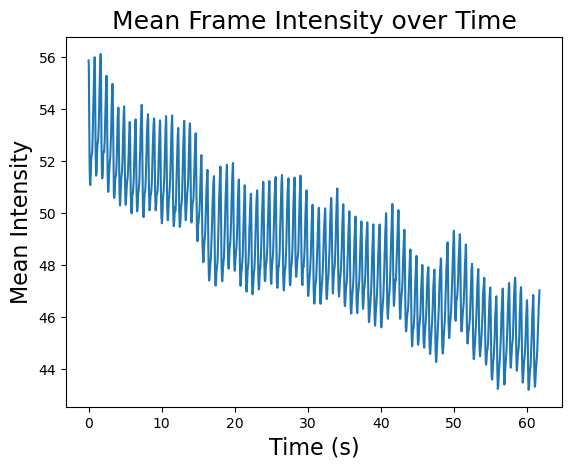

In [38]:
## Here we plot the mean intensity over the time elapsed
## Weirdly we can see the intensity lowers over time. This may be due to the camera adjusting to the light
## level.

plt.plot(time_elapsed, mean_intensity)
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Mean Intensity', fontsize=16)
plt.title('Mean Frame Intensity over Time', fontsize=18)
plt.savefig('Mean_intensity_plot')

Visually, we can count ~73BPM from this plot (counting the intensity peaks). We can use this to determine whether the calculated dominant frequency is correct.

## Calculating the BPM

Here we calculate the FFT of the mean intensity. This is used to calculate the dominant frequency, power, and bpm.

In [8]:
hb_fft = np.fft.fft(mean_intensity) ## Calculates FFT

freq_array = np.arange(1852) * (sampling_frequency / 1852) 
## Creates a frequency array in equal intervals up to our sampling freqeuncy.

hb_fft_power = np.power(np.abs(hb_fft), 2) / len(mean_intensity)
## Calculates an array of each frames power 

Because the camera needs time to adjust, I decided to remove the first 10 instances in the freq array, power array, and FFT array.

In [9]:
new_hb_fft = hb_fft[10:] ## Removes the first 10 instances from the fft
new_hb_power = hb_fft_power[10:] ## Removes first 10 from the power array
new_freq_array = freq_array[10:] ## Removes first 10 from the freq array

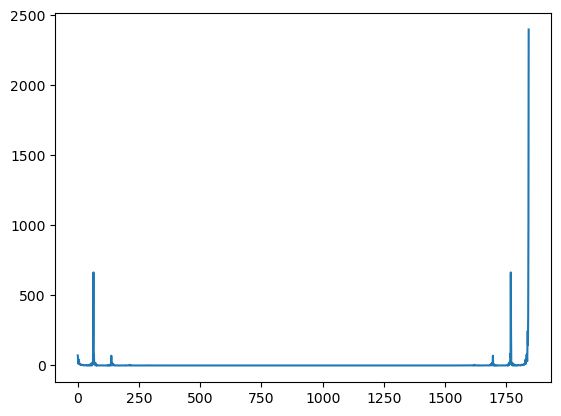

In [10]:
plt.plot(new_hb_power) ## Plots power

Here we can see the plot of the power over the frequency array. The highest power is right at the end towards ~30Hz. This is the sampling frequency, thus I have decided to limit the graph to <25 to ignore these frequencies that may be due to the sampling.

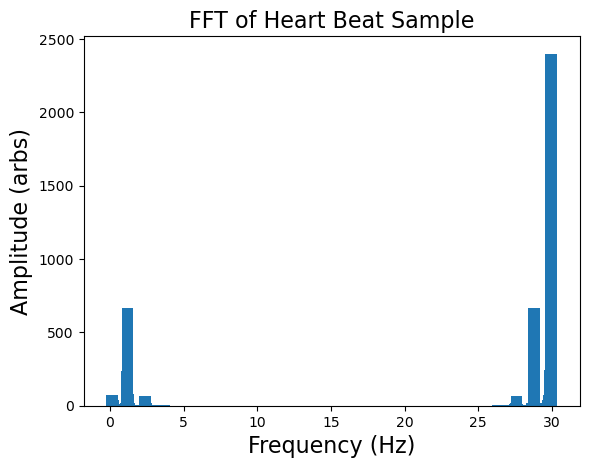

In [39]:
plt.bar(new_freq_array, new_hb_power) ## Plots the power over the freq array
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Amplitude (arbs)', fontsize=16)
plt.title('FFT of Heart Beat Sample', fontsize=16)
plt.savefig('new_fft')

Here is the same plot but I have removed any values in which the freq_array are above 25Hz.

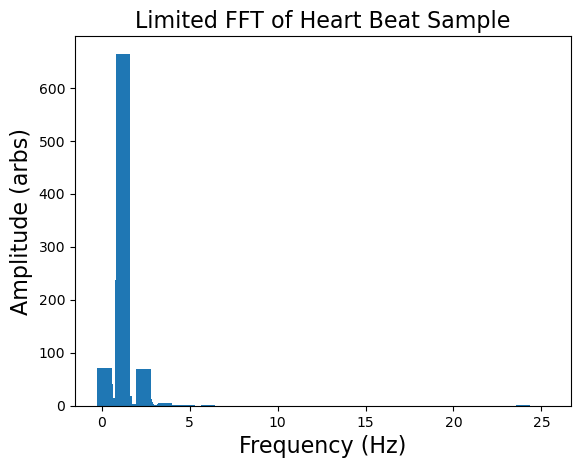

In [41]:
new_limited_25 = new_freq_array[new_freq_array < 25] ## Limits the freq array to 25
new_lim_25 = new_hb_power[new_freq_array < 25] ## Only keeps the power where freq is <25

plt.bar(new_limited_25, new_lim_25) ## Plots the limited power over freq < 25
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Amplitude (arbs)', fontsize=16)
plt.title('Limited FFT of Heart Beat Sample', fontsize=16)
plt.savefig('limited_fft')

Now we can calculate the index of the dominant frequency. This gives the index of the highest power from the new power array which we can then sub into the new frequency array for the dominant frequency.

In [13]:
dom_freq = np.argmax(new_lim_25) ## Gives the index of the max power from the new power array.
dom_freq

64

In [14]:
dominant_hb_freq = new_limited_25[64] ## Finds the frequency value at the index of the highest power.
dominant_hb_freq

1.1979049676025917

In [15]:
bpm = dominant_hb_freq * 60 ## Multiply the freq by 60 as the freq is the freq per second, thus bpm is * 60
bpm

71.8742980561555

From this, we have calculated a bpm of ~72bpm. This is very similar to the value calculated by hand.